In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('DATASET.csv')
print(data.head())
print(data.shape)

                                              Review     label
0  Great music service, the audio is high quality...  POSITIVE
1  Please ignore previous negative rating. This a...  POSITIVE
2  This pop-up "Get the best Spotify experience o...  NEGATIVE
3    Really buggy and terrible to use as of recently  NEGATIVE
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE
(52702, 2)


In [3]:
data.isna().sum()

Review    16
label      0
dtype: int64

In [4]:
data = data.dropna()
data.shape

(52686, 2)

In [5]:
data['Review'] = data['Review'].astype(str).str.replace(r'Ã[\x80-\xBF]+|[^a-zA-Z\s]|\s+', ' ', regex=True).str.strip().str.lower()

In [6]:
tokenized_reviews = []
for review in data['Review']:
    tokens = word_tokenize(review)
    tokenized_reviews.append(tokens)
data['Review Tokenized'] = tokenized_reviews
data.head()

,Review,label,Review Tokenized
0,great music service the audio is high quality...,POSITIVE,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating this a...,POSITIVE,"[please, ignore, previous, negative, rating, t..."
2,this pop up get the best spotify experience o...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ..."


In [7]:
stop_words = stopwords.words('english')
custom_stopwords = ['app', 'music', 'play', 'spotify', 'song', 'songs', 'listen', 'playing', 'get', 'playlist']
reviews_no_stopwords = []
for review in data['Review Tokenized']:
    review_no_stopwords = [word for word in review if (word not in stop_words) and (word not in custom_stopwords)]
    reviews_no_stopwords.append(review_no_stopwords)
data['Review Without Stopwords'] = reviews_no_stopwords
data.head()

,Review,label,Review Tokenized,Review Without Stopwords
0,great music service the audio is high quality...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, service, audio, high, quality, easy, u..."
1,please ignore previous negative rating this a...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[please, ignore, previous, negative, rating, s..."
2,this pop up get the best spotify experience o...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, best, experience, android, annoying, ple..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, put, shuffle]"


In [8]:
lemmatizer = WordNetLemmatizer()
lemmatized_reviews = []
for review in data['Review Without Stopwords']:
    lemmatized_review = [lemmatizer.lemmatize(word,pos='v') for word in review]
    lemmatized_reviews.append(lemmatized_review)
data['Review Lemmatized'] = lemmatized_reviews
data.head()

,Review,label,Review Tokenized,Review Without Stopwords,Review Lemmatized
0,great music service the audio is high quality...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, service, audio, high, quality, easy, u...","[great, service, audio, high, quality, easy, u..."
1,please ignore previous negative rating this a...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[please, ignore, previous, negative, rating, s...","[please, ignore, previous, negative, rat, supe..."
2,this pop up get the best spotify experience o...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, best, experience, android, annoying, ple...","[pop, best, experience, android, annoy, please..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, put, shuffle]","[dear, put, shuffle]"


In [9]:
processed_reviews = []
for review in data['Review Lemmatized']:
    review = ' '.join(review)
    processed_reviews.append(review)
data['Processed Reviews'] = processed_reviews
data.head()

,Review,label,Review Tokenized,Review Without Stopwords,Review Lemmatized,Processed Reviews
0,great music service the audio is high quality...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, service, audio, high, quality, easy, u...","[great, service, audio, high, quality, easy, u...",great service audio high quality easy use also...
1,please ignore previous negative rating this a...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[please, ignore, previous, negative, rating, s...","[please, ignore, previous, negative, rat, supe...",please ignore previous negative rat super grea...
2,this pop up get the best spotify experience o...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, best, experience, android, annoying, ple...","[pop, best, experience, android, annoy, please...",pop best experience android annoy please let rid
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]",really buggy terrible use recently
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, put, shuffle]","[dear, put, shuffle]",dear put shuffle


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Processed Reviews'])
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17448

In [11]:
input_sequences = tokenizer.texts_to_sequences(data['Review'])
input_sequences = np.array(pad_sequences(input_sequences, padding='pre'))

In [12]:
y = data['label'].map({'POSITIVE':1, 'NEGATIVE':0})
y

0        1
1        1
2        0
3        0
4        0
        ..
52697    1
52698    1
52699    1
52700    1
52701    1
Name: label, Length: 52686, dtype: int64

In [13]:
x_train, x_test, y_train, y_test = train_test_split(input_sequences, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [14]:
x_train.shape

(31611, 118)

In [ ]:
model = Sequential([
    Embedding(vocab_size,131),
    Bidirectional(LSTM(131, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',mode='max',patience=5,verbose=1, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 438s 441ms/step - accuracy: 0.8108 - loss: 0.4160 - val_accuracy: 0.8687 - val_loss: 0.3093
Epoch 2/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 195s 197ms/step - accuracy: 0.8919 - loss: 0.2686 - val_accuracy: 0.8667 - val_loss: 0.3109
Epoch 3/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 419s 424ms/step - accuracy: 0.9078 - loss: 0.2201 - val_accuracy: 0.8635 - val_loss: 0.3231
Epoch 4/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 2218s 2s/step - accuracy: 0.9239 - loss: 0.1914 - val_accuracy: 0.8605 - val_loss: 0.3342
Epoch 5/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 202s 205ms/step - accuracy: 0.9327 - loss: 0.1686 - val_accuracy: 0.8528 - val_loss: 0.3939
Epoch 6/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 651s 660ms/step - accuracy: 0.9438 - loss: 0.1426 - val_accuracy: 0.8501 - val_loss: 0.4523
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


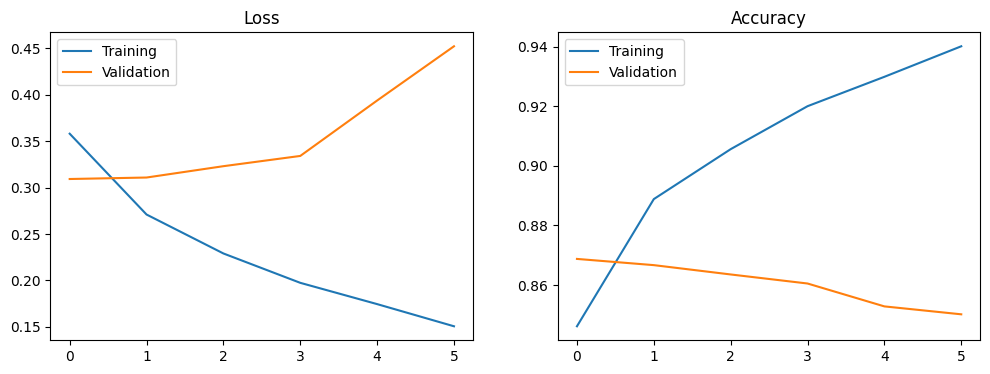

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()

In [ ]:
pred = model.predict(x_test)
y_pred = [(1 if p>=0.5 else 0) for p in pred]
y_test = list(y_test)
matching = [(1 if y_pred[i]==y_test[i] else 0) for i in range(len(y_test))]
test_accuracy = np.sum(matching)/len(matching)
accuracy = f'{test_accuracy*100:.2f}%'
print('Test Accuracy:',test_accuracy)

330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step
Test Accuracy: 0.8649648889732398


In [17]:
# class TransformerBlock(Layer):
#     def __init__(self, d_model, num_heads, dropout_rate=0.2):
#         super().__init__()
#         self.attn = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
#         self.ffn = tf.keras.Sequential([
#             Dense(d_model * 2, activation='relu'),
#         ])
#         self.norm1 = LayerNormalization(epsilon=1e-6)
#         self.norm2 = LayerNormalization(epsilon=1e-6)
#         self.dropout1 = Dropout(dropout_rate)
#         self.dropout2 = Dropout(dropout_rate)

#     def call(self, inputs):
#         attn_output = self.attn(inputs, inputs, inputs)
#         out1 = self.norm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output)
#         out2 = self.norm2(out1 + ffn_output)
#         return out2

def transformer(vocab_size, max_len, d_model, num_layers, num_heads):
    input_ids = Input(shape=(max_len,))
    token_embeddings = Embedding(vocab_size, d_model)(input_ids)
    x = token_embeddings
    for _ in range(num_layers):
        # x = TransformerBlock(d_model, num_heads)(x)
        x1 = MultiHeadAttention(num_heads, d_model)(x,x,x)
        x1 = Dropout(0.2)(x1)
        x2 = LayerNormalization(epsilon=1e-6)(x + x1)
        x3 = Dense(d_model * 2, activation='relu')(x2)
        x3 = Dense(d_model, activation='relu')(x3)
        x3 = Dropout(0.2)(x3)
        x = LayerNormalization(epsilon=1e-6)(x2 + x3)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_ids, outputs=outputs)
    return model

model1 = transformer(vocab_size=vocab_size, max_len=x_train.shape[1], d_model=32, num_layers=3, num_heads=4)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2, patience=1, verbose=1, min_lr=0.0001)
history1=model1.fit(x_train,y_train,epochs=5,validation_data=(x_val,y_val),batch_size=256,verbose=1,callbacks=[reduce_lr])

Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 73s 564ms/step - accuracy: 0.6431 - loss: 0.6458 - val_accuracy: 0.8579 - val_loss: 0.3388 - learning_rate: 0.0010
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8723 - loss: 0.3074
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
124/124 ━━━━━━━━━━━━━━━━━━━━ 69s 558ms/step - accuracy: 0.8723 - loss: 0.3074 - val_accuracy: 0.8566 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 72s 585ms/step - accuracy: 0.8966 - loss: 0.2521 - val_accuracy: 0.8585 - val_loss: 0.3417 - learning_rate: 2.0000e-04
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9088 - loss: 0.2324
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001.
124/124 ━━━━━━━━━━━━━━━━━━━━ 70s 567ms/step - accuracy: 0.9087 - loss: 0.2324 - val_accuracy: 0.8557 - val_loss: 0.3529 - learning_rate: 2.0000e-04
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 70s 563ms/step - accuracy: 0.9096 - loss: 0.2

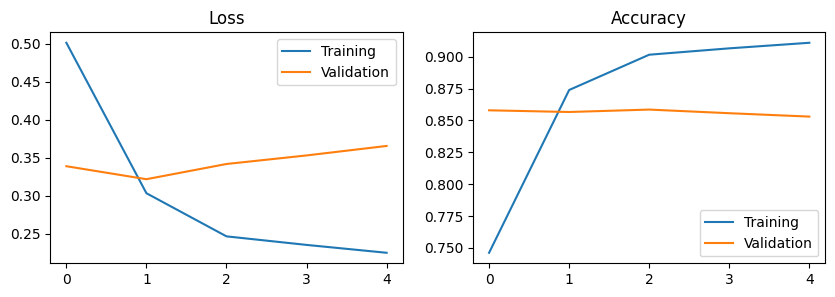

In [19]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend()

In [20]:
pred1 = model1.predict(x_test)
y_pred1 = [(1 if p>=0.5 else 0) for p in pred1]
y_test = list(y_test)
matching1 = [(1 if y_pred1[i]==y_test[i] else 0) for i in range(len(y_test))]
test_accuracy1 = np.sum(matching1)/len(matching1)
accuracy1 = f'{test_accuracy1*100:.2f}%'
print('Test Accuracy:',test_accuracy1)

330/330 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
Test Accuracy: 0.8525336876067565


In [21]:
with open('README.txt','w') as f:
    f.write('Model Accuracy: '+f'{max(test_accuracy,test_accuracy1)*100:.2f}%')